In [1]:
import os
import sys
import gc
import time
import warnings
import pickle
import random
import statistics


import numpy as np
import pandas as pd
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psutil
from google.cloud import storage, bigquery
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import transformers
import torch
from statsforecast.models import (
    AutoETS
)
from statsforecast import StatsForecast
from sklearn.metrics import mean_squared_error


import timesfm
from timesfm import patched_decoder, data_loader
import timesfm as tfm


# import jax
# from jax import numpy as jnp
# from praxis import (
#     pax_fiddle, py_utils, pytypes, base_model, optimizers, schedules,
#     base_hyperparams, base_layer
# )
# from paxml import (
#     tasks_lib, trainer_lib, checkpoints, learners,
#     partitioning, checkpoint_types
# )
# warnings.filterwarnings("ignore", category=FutureWarning)



# Matplotlib Settings
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Pandas Display Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Initialize Google BigQuery Client
client = bigquery.Client()

# Seed Settings for Reproducibility
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)
transformers.set_seed(1)


TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


DataFrame Head:
     ID       date  target
0  ID_1 2018-01-01      29
1  ID_1 2018-02-01      23
2  ID_1 2018-03-01      19
3  ID_1 2018-04-01      60
4  ID_1 2018-05-01      38

DataFrame Tail:
              ID       date  target
179995  ID_10000 2019-02-01     177
179996  ID_10000 2019-03-01     209
179997  ID_10000 2019-04-01     210
179998  ID_10000 2019-05-01      92
179999  ID_10000 2019-06-01     208

DataFrame Shape: (180000, 3)


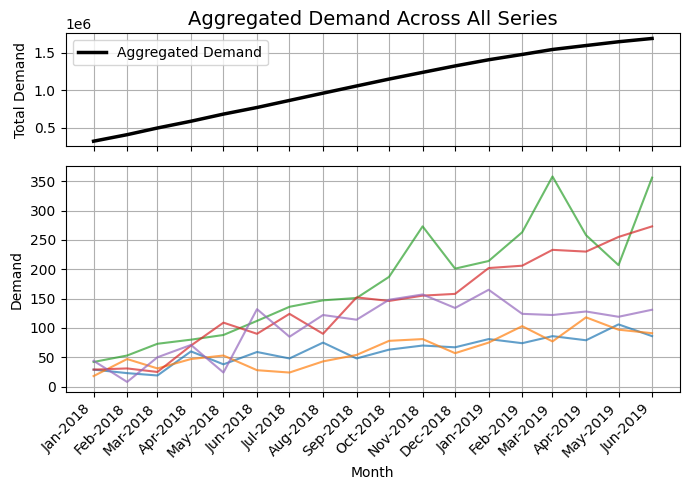

In [2]:
# Define trend generation functions
def generate_linear_trend(length, start_level, growth_rate, damping_factor):
    months = np.arange(length)
    trend = start_level + growth_rate * months * (1 - damping_factor * months)
    return trend

def generate_logistic_trend(length, start_level, max_level, growth_speed):
    months = np.arange(length)
    midpoint = length / 2.0
    logistic_raw = max_level / (1 + np.exp(-growth_speed*(months - midpoint)))
    adjustment = logistic_raw[0] - start_level
    trend = logistic_raw - adjustment
    return trend

def generate_polynomial_trend(length, start_level, a, b, c):
    t = np.arange(length)
    trend = a * t**2 + b * t + c
    trend += (start_level - trend[0])  # shift to start at start_level
    return trend

def add_random_noise(series, additive_scale, multiplicative_scale):
    additive_noise = np.random.normal(0, additive_scale, size=len(series))
    multiplicative_noise = np.random.normal(0, multiplicative_scale, size=len(series))
    multiplier = 1 + multiplicative_noise
    noisy_series = (series + additive_noise) * multiplier
    return noisy_series

# Parameters
num_series = 10000
length = 18

all_series = []


for _ in range(num_series):
    # Randomly select a trend type
    trend_type = np.random.choice(['linear', 'logistic', 'polynomial'], p=[0.34, 0.33, 0.33])
    
    # Common random parameters
    start_level = np.random.uniform(10, 50)  # starting demand
    additive_scale = np.random.uniform(10, 50)
    multiplicative_scale = np.random.uniform(0.05, 0.2)
    
    if trend_type == 'linear':
        growth_rate = np.random.uniform(2, 30)
        damping_factor = np.random.uniform(0.01, 0.05)
        series = generate_linear_trend(length, start_level, growth_rate, damping_factor)
        
    elif trend_type == 'logistic':
        max_level = np.random.uniform(start_level + 30, start_level + 200)
        growth_speed = np.random.uniform(0.1, 0.5)
        series = generate_logistic_trend(length, start_level, max_level, growth_speed)
        
    else:  # polynomial
        a = np.random.uniform(-0.2, 0.2) 
        b = np.random.uniform(5, 15)
        c = 0
        series = generate_polynomial_trend(length, start_level, a, b, c)
    
    # Decide error distribution
    if np.random.rand() < 0.5:
        # Mostly additive noise
        multiplicative_scale *= 0.5
    else:
        # Mostly multiplicative noise
        additive_scale *= 0.5
    
    # Add noise
    series = add_random_noise(series, additive_scale, multiplicative_scale)
    
    # Clip negatives
    series = np.clip(series, 0, None)
    
    # Round to nearest integer
    series = np.rint(series).astype(int)
    
    all_series.append(series)

all_series = np.array(all_series)  

# Create a date range for the 18 months starting from 2018-01-01
dates = pd.date_range(start='2018-01-01', periods=length, freq='MS')  # 'MS' for Month Start

# Create a DataFrame in long format
ids = [f"ID_{i+1}" for i in range(num_series)]

df = pd.DataFrame({
    'ID': np.repeat(ids, length),
    'date': np.tile(dates, num_series),
    'target': all_series.flatten()
})

# Display DataFrame information (optional)
print("DataFrame Head:")
print(df.head())
print("\nDataFrame Tail:")
print(df.tail())
print("\nDataFrame Shape:", df.shape)

# Select 10 individual series to plot
selected_ids = ids[:5]  # First 10 IDs; you can change this to any 10 IDs as needed

# Compute aggregated demand
aggregated = df.groupby('date')['target'].sum().reset_index()

# Create the split plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True,
                               gridspec_kw={'height_ratios': [1, 2]})

# Top subplot: Aggregated Demand
ax1.plot(aggregated['date'], aggregated['target'], color='black', linewidth=2.5, label='Aggregated Demand')
ax1.set_title("Aggregated Demand Across All Series", fontsize=14)
ax1.set_ylabel("Total Demand")
ax1.legend()
ax1.grid(True)

# Bottom subplot: 10 Individual Series
for id_ in selected_ids:
    subset = df[df['ID'] == id_]
    ax2.plot(subset['date'], subset['target'], alpha=0.7, label=id_)

# ax2.set_title("10 Individual Demand Series", fontsize=14)
ax2.set_xlabel("Month")
ax2.set_ylabel("Demand")
# ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place legend outside the plot
ax2.grid(True)

# Format the x-axis to show months
ax2.xaxis.set_major_locator(mdates.MonthLocator())  # Place a tick for each month
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))  # Format ticks as 'Jan-2018', etc.
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [3]:
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by 'ID' and 'date'
df = df.sort_values(['ID', 'date'])

# Define the number of test periods
n_test = 6

# Split into train and test sets
df_train = df.groupby('ID').apply(lambda x: x.iloc[:-n_test]).reset_index(drop=True)
df_test = df.groupby('ID').apply(lambda x: x.iloc[-n_test:]).reset_index(drop=True)

print("Training Set Shape:", df_train.shape)
print("Testing Set Shape:", df_test.shape)

/var/tmp/ipykernel_2056546/1112254795.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df.groupby('ID').apply(lambda x: x.iloc[:-n_test]).reset_index(drop=True)


Training Set Shape: (120000, 3)
Testing Set Shape: (60000, 3)


/var/tmp/ipykernel_2056546/1112254795.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test = df.groupby('ID').apply(lambda x: x.iloc[-n_test:]).reset_index(drop=True)


In [ ]:
# chronos forecast
train_time_series_data = TimeSeriesDataFrame.from_data_frame(df_train, id_column='ID', timestamp_column='date')
predictor = TimeSeriesPredictor(
        prediction_length=6,  
        target='target',
        eval_metric='RMSE',
        freq='MS',
    )

predictor.fit(train_time_series_data,
    presets='chronos_large',
    hyperparameters={
        'Chronos': {
            'model_path': 'large',
            'batch_size': 32,
            'device': 'cuda',
                # 'data_loader_num_workers': 64,
                # 'optimization_strategy': 'openvino',
            }
        },
        skip_model_selection=True,          
    )
predictor.persist()
forecast_chronos = predictor.predict(train_time_series_data).reset_index()

In [ ]:
forecast_chronos.to_csv('/home/jupyter/llm/trend_only_simulation_chronoslarge.csv', index= False)

In [4]:
# TimesFM forecast
df_train_tfm = df_train.rename(columns={
    'ID': 'unique_id',
    'date': 'ds',
    'target': 'values'
})
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=6,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m"),
  )
tfm._median_index = -1 
forecast_tfm = tfm.forecast_on_df(
        inputs=df_train_tfm,
        freq='MS',
        num_jobs=-1, 
    )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

2024-12-20 20:41:48.126162: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Multiprocessing context has already been set.
Constructing model weights.


Constructed model weights in 2.90 seconds.
Restoring checkpoint from /home/jupyter/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.94 seconds.
Jitting decoding.
Jitted decoding in 17.54 seconds.
Processing dataframe with multiple processes.


/opt/conda/envs/llm_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.


In [5]:
forecast_tfm.to_csv('/home/jupyter/llm/trend_only_simulation_tfm.csv', index= False)

In [6]:
# forecast ETS
df_train_ets = df_train.rename(columns={
    'ID': 'unique_id',
    'date': 'ds',
    'target': 'y'
})

models = [
    AutoETS()
]

sf = StatsForecast( 
    models=models,
    freq="MS", 
    n_jobs=-1,
)
forecast_ets = sf.forecast(df=df_train_ets, h=6, level=[90])
forecast_ets.head()
forecast_ets = forecast_ets.reset_index()

/opt/conda/envs/llm_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/envs/llm_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/envs/llm_env/lib/python3.10/site-packages/statsforecast/core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
forecast_ets.to_csv('/home/jupyter/llm/trend_only_simulation_ets.csv', index= False)

In [8]:
forecast_chronos = pd.read_csv('/home/jupyter/llm/trend_only_simulation_chronoslarge.csv')
forecast_tfm = pd.read_csv('/home/jupyter/llm/trend_only_simulation_tfm.csv')
forecast_ets = pd.read_csv('/home/jupyter/llm/trend_only_simulation_ets.csv')

RMSE of Chronos Forecast (Median): 68.53
RMSE of TFM Forecast (Median): 67.73
RMSE of ETS Forecast: 53.52


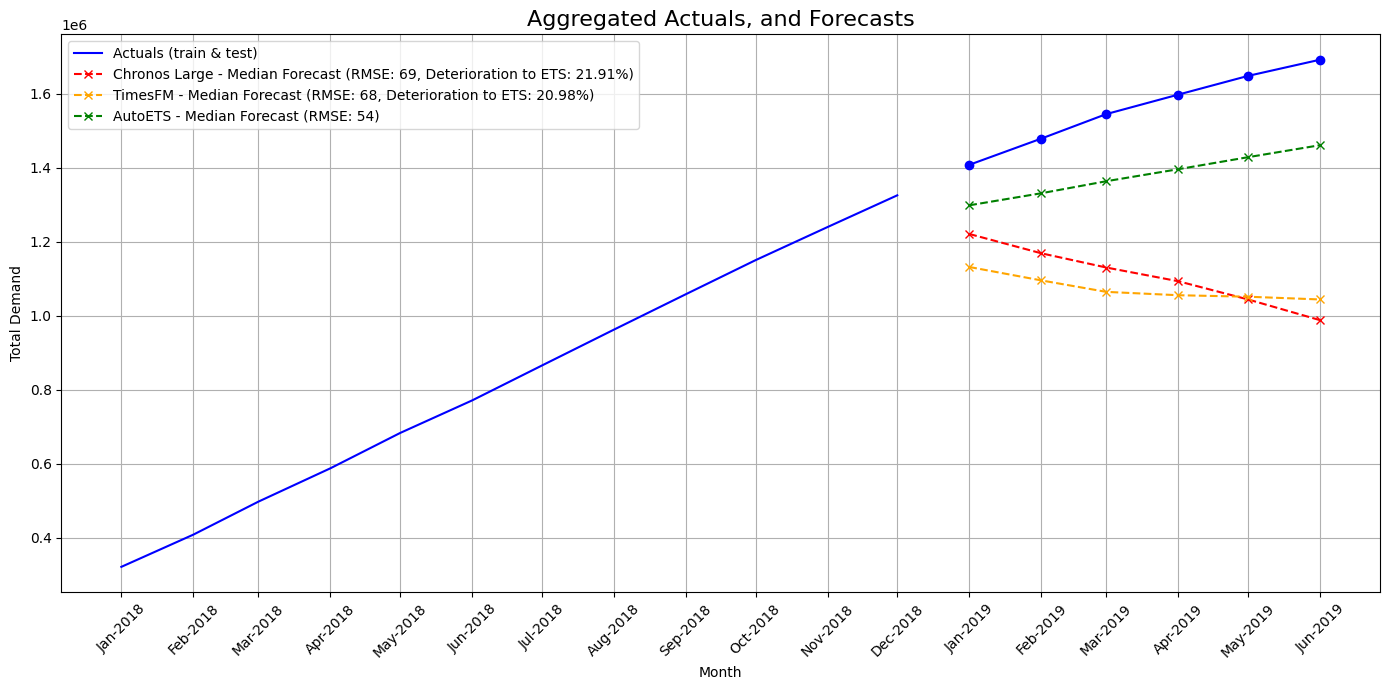

In [9]:
# Ensure that 'date' columns are in datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# For forecast_chronos
forecast_chronos['timestamp'] = pd.to_datetime(forecast_chronos['timestamp'])
forecast_chronos_renamed = forecast_chronos.rename(columns={
    'item_id': 'ID',
    'timestamp': 'date',
    '0.5': 'chronos_forecast'
})

# For forecast_tfm
forecast_tfm['ds'] = pd.to_datetime(forecast_tfm['ds'])
forecast_tfm_renamed = forecast_tfm.rename(columns={
    'unique_id': 'ID',
    'ds': 'date',
    'timesfm-q-0.5': 'tfm_forecast'
})

# For forecast_ets
forecast_ets['ds'] = pd.to_datetime(forecast_ets['ds'])
forecast_ets_renamed = forecast_ets.rename(columns={
    'unique_id': 'ID',
    'ds': 'date',
    'AutoETS': 'ets_forecast'
})

# ----------------------------
# 2. Merging Forecasts with Actuals
# ----------------------------

# Merge Chronos forecast with df_test
merged_chronos = pd.merge(df_test, forecast_chronos_renamed[['ID', 'date', 'chronos_forecast']],
                          on=['ID', 'date'], how='left')

# Merge TFM forecast with df_test
merged_tfm = pd.merge(df_test, forecast_tfm_renamed[['ID', 'date', 'tfm_forecast']],
                      on=['ID', 'date'], how='left')

# Merge ETS forecast with df_test
merged_ets = pd.merge(df_test, forecast_ets_renamed[['ID', 'date', 'ets_forecast']],
                      on=['ID', 'date'], how='left')

# ----------------------------
# 3. Calculating RMSE for Each Model
# ----------------------------

# Aggregate df_test by date (sum across all IDs)
test_agg = df_test.groupby('date')['target'].sum().reset_index()

# Aggregate forecasts by date (sum across all IDs)
forecast_chronos_agg = merged_chronos.groupby('date')['chronos_forecast'].sum().reset_index()
forecast_tfm_agg = merged_tfm.groupby('date')['tfm_forecast'].sum().reset_index()
forecast_ets_agg = merged_ets.groupby('date')['ets_forecast'].sum().reset_index()

# Calculate RMSE between each ID actuals and each forecast
rmse_chronos = np.sqrt(mean_squared_error(merged_chronos['target'], merged_chronos['chronos_forecast']))
rmse_tfm = np.sqrt(mean_squared_error(merged_tfm['target'], merged_tfm['tfm_forecast']))
rmse_ets = np.sqrt(mean_squared_error(merged_ets['target'], merged_ets['ets_forecast']))

print(f"RMSE of Chronos Forecast (Median): {rmse_chronos:.2f}")
print(f"RMSE of TFM Forecast (Median): {rmse_tfm:.2f}")
print(f"RMSE of ETS Forecast: {rmse_ets:.2f}")

# ----------------------------
# 4. Aggregating Historical Data
# ----------------------------

# Aggregate df_train by date (sum across all IDs)
train_agg = df_train.groupby('date')['target'].sum().reset_index()

# ----------------------------
# 5. Plotting Aggregated Data with RMSE Annotations
# ----------------------------


# Avoid division by zero
if rmse_ets != 0:
    deterioration_chronos = round(((rmse_chronos - rmse_ets) / rmse_chronos) * 100, 2)
    deterioration_tfm = round(((rmse_tfm - rmse_ets) / rmse_tfm) * 100, 2)
    # ETS is the baseline, so deterioration is 0%
    deterioration_ets = 0.00
else:
    deterioration_chronos = np.nan
    deterioration_tfm = np.nan
    deterioration_ets = np.nan

# ----------------------------
# 6. Aggregating Historical Data
# ----------------------------

# Aggregate df_train by date (sum across all IDs)
train_agg = df_train.groupby('date')['target'].sum().reset_index()

# ----------------------------
# 7. Plotting Aggregated Data with RMSE and Deterioration Annotations
# ----------------------------

plt.figure(figsize=(14, 7))

# Plot Aggregated Historical Data (Train) and Actuals (Test) in the same color
plt.plot(train_agg['date'], train_agg['target'], label='Actuals (train & test)', color='blue')
plt.plot(test_agg['date'], test_agg['target'], color='blue', marker='o')

# Plot Aggregated Forecasts
plt.plot(forecast_chronos_agg['date'], forecast_chronos_agg['chronos_forecast'],
         label=f'Chronos Large - Median Forecast (RMSE: {round(rmse_chronos)}, Deterioration to ETS: {deterioration_chronos}%)',
         color='red', linestyle='--', marker='x')
plt.plot(forecast_tfm_agg['date'], forecast_tfm_agg['tfm_forecast'],
         label=f'TimesFM - Median Forecast (RMSE: {round(rmse_tfm)}, Deterioration to ETS: {deterioration_tfm}%)',
         color='orange', linestyle='--', marker='x')
plt.plot(forecast_ets_agg['date'], forecast_ets_agg['ets_forecast'],
         label=f'AutoETS - Median Forecast (RMSE: {round(rmse_ets)})',
         color='green', linestyle='--', marker='x')

# Formatting the x-axis to show months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Ticks every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # Format as 'Jan-2019', etc.
plt.xticks(rotation=45)

# Adding titles and labels
plt.title("Aggregated Actuals, and Forecasts", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Total Demand")

# Adding legend
plt.legend()

# Adding grid for better readability
plt.grid(True)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Display the plot
plt.show()

In [10]:
def plot_forecasts_for_id(id, df_train, df_test, merged_chronos, merged_tfm, merged_ets):
    """
    Plots the historical data, actual test data, and forecasts from Chronos, TFM, and ETS models for a specified ID.
    
    Parameters:
    - id (str): The unique identifier (e.g., 'ID_1') to plot.
    - df_train (DataFrame): Training data with columns ['ID', 'date', 'target'].
    - df_test (DataFrame): Testing data with columns ['ID', 'date', 'target'].
    - merged_chronos (DataFrame): Chronos forecast merged with df_test.
    - merged_tfm (DataFrame): TFM forecast merged with df_test.
    - merged_ets (DataFrame): ETS forecast merged with df_test.
    """
    
    # ----------------------------
    # 1. Filter Data for the Specified ID
    # ----------------------------
    
    # Historical (Train) Data
    df_train_id = df_train[df_train['ID'] == id]
    
    # Actual Test Data
    df_test_id = df_test[df_test['ID'] == id]
    
    # Chronos Forecast Data
    merged_chronos_id = merged_chronos[merged_chronos['ID'] == id]
    
    # TFM Forecast Data
    merged_tfm_id = merged_tfm[merged_tfm['ID'] == id]
    
    # ETS Forecast Data
    merged_ets_id = merged_ets[merged_ets['ID'] == id]
    
    # ----------------------------
    # 2. Calculate RMSE for Each Model
    # ----------------------------
    
    # Ensure that there are matching dates
    common_dates = df_test_id['date'].isin(merged_chronos_id['date']) & \
                   df_test_id['date'].isin(merged_tfm_id['date']) & \
                   df_test_id['date'].isin(merged_ets_id['date'])
    
    if not common_dates.all():
        print(f"Warning: Some dates in df_test for {id} are missing in the forecasts.")
    
    # Actual Values
    actuals = df_test_id['target'].values
    
    # Forecasted Values
    chronos_forecast = merged_chronos_id['chronos_forecast'].values
    tfm_forecast = merged_tfm_id['tfm_forecast'].values
    ets_forecast = merged_ets_id['ets_forecast'].values
    
    # Calculate RMSE
    rmse_chronos = np.sqrt(mean_squared_error(actuals, chronos_forecast))
    rmse_tfm = np.sqrt(mean_squared_error(actuals, tfm_forecast))
    rmse_ets = np.sqrt(mean_squared_error(actuals, ets_forecast))
    
    # Round RMSE values to two decimal places
    rmse_chronos = round(rmse_chronos, 2)
    rmse_tfm = round(rmse_tfm, 2)
    rmse_ets = round(rmse_ets, 2)
    
    # Calculate Percentage Deterioration Relative to ETS
    if rmse_ets != 0:
        deterioration_chronos = round(((rmse_chronos - rmse_ets) / rmse_ets) * 100, 2)
        deterioration_tfm = round(((rmse_tfm - rmse_ets) / rmse_ets) * 100, 2)
    else:
        deterioration_chronos = np.nan
        deterioration_tfm = np.nan
    
    # ----------------------------
    # 3. Aggregate Historical and Forecast Data
    # ----------------------------
    
    # Aggregated Historical Data
    train_agg = df_train_id.groupby('date')['target'].sum().reset_index()
    
    # Aggregated Actuals
    test_agg = df_test_id.groupby('date')['target'].sum().reset_index()
    
    # Aggregated Forecasts
    forecast_chronos_agg = merged_chronos_id.groupby('date')['chronos_forecast'].sum().reset_index()
    forecast_tfm_agg = merged_tfm_id.groupby('date')['tfm_forecast'].sum().reset_index()
    forecast_ets_agg = merged_ets_id.groupby('date')['ets_forecast'].sum().reset_index()
    
    # ----------------------------
    # 4. Plotting
    # ----------------------------
    
    plt.figure(figsize=(14, 7))
    
    # Plot Historical Data (Train)
    plt.plot(train_agg['date'], train_agg['target'], label='Historical (Train)', color='blue')
    
    # Plot Actual Test Data
    plt.plot(test_agg['date'], test_agg['target'], label='Actuals (Test)', color='blue', marker='o')
    
    # Plot Chronos Forecast
    plt.plot(forecast_chronos_agg['date'], forecast_chronos_agg['chronos_forecast'],
             label=f'Chronos Forecast (RMSE: {rmse_chronos}, Deterioration: {deterioration_chronos}%)',
             color='red', linestyle='--', marker='x')
    
    # Plot TFM Forecast
    plt.plot(forecast_tfm_agg['date'], forecast_tfm_agg['tfm_forecast'],
             label=f'TFM Forecast (RMSE: {rmse_tfm}, Deterioration: {deterioration_tfm}%)',
             color='orange', linestyle='--', marker='x')
    
    # Plot ETS Forecast
    plt.plot(forecast_ets_agg['date'], forecast_ets_agg['ets_forecast'],
             label=f'ETS Forecast (RMSE: {rmse_ets})',
             color='green', linestyle='--', marker='x')
    
    # Formatting the x-axis to show months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.xticks(rotation=45)
    
    # Adding titles and labels
    plt.title(f"Aggregated Demand Forecast for {id}", fontsize=16)
    plt.xlabel("Month")
    plt.ylabel("Total Demand")
    
    # Adding legend
    plt.legend()
    
    # Adding grid for better readability
    plt.grid(True)
    
    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()
    
    # Display the plot
    plt.show()


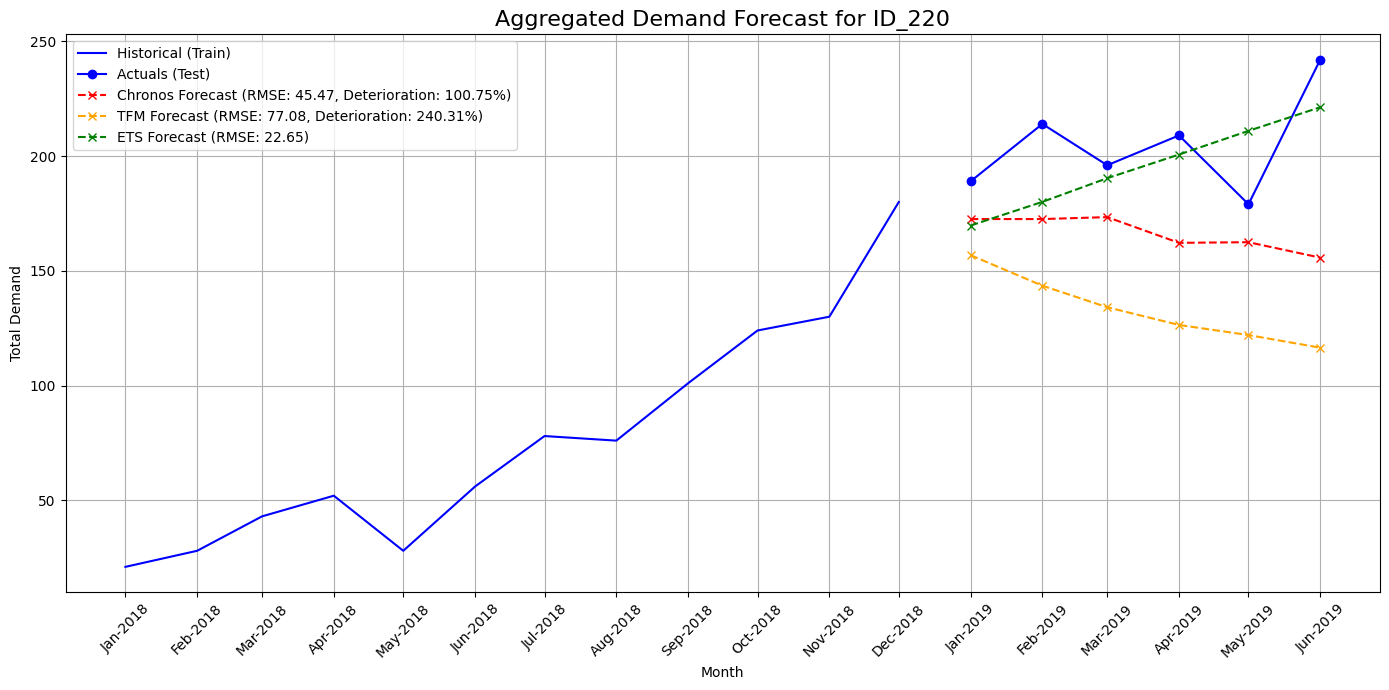

In [12]:
# Example ID to plot
specific_id = 'ID_220'

# Call the plotting function
plot_forecasts_for_id(specific_id, df_train, df_test, merged_chronos, merged_tfm, merged_ets)
